In [1]:
import sys

sys.path.insert(0, "..")

from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import numpy as np
import torch
from kornia import augmentation
from kornia.augmentation.container import AugmentationSequential
from kornia.constants import Resample

root = "/home/jluesch/Documents/data/plankton/nat_lmdb/"
ds_path = f"LMDBDataset:split=TRAIN:root={root}:extra=*"

/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [2]:
data_transform_cpu = DataAugmentationDINO(
    [0.8, 1.0],
    [0.05, 0.32],
    6,
    global_crops_size=224,
    local_crops_size=96,
    use_kornia=True,
    use_native_res=True,
    do_seg_crops=True,
    patch_size=14
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda x: x,
    with_targets=True,
    cache_dataset=False,
)

Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/jluesch/Documents/data/plankton/nat_lmdb/', 'extra': '*'}
extra_path /home/jluesch/Documents/data/plankton/nat_lmdb/*-TRAIN_*
Datasets labels file list:  ['/home/jluesch/Documents/data/plankton/nat_lmdb/2007-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2008-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2009-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2010-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2011-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2012-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2013-TRAIN_labels', '/home/jluesch/Documents/data/plankton/nat_lmdb/2014-TRAIN_labels']
Datasets imgs file list:  ['/home/jluesch/Documents/data/plankton/nat_lmdb/2007-TRAIN_imgs', '/home/jluesch/Documents/data/plankton/nat_lmdb/2008-TRAIN_imgs', '/home/jluesch/Documents/data/plankton/nat_lmdb/2009-TRAIN_imgs', '/home/jlue

__call__ aug torch.Size([3, 156, 321])
torch.Size([3, 14, 3864])
__call__ aug torch.Size([3, 195, 257])
torch.Size([3, 14, 3724])
__call__ aug torch.Size([3, 162, 310])
torch.Size([3, 14, 3864])
__call__ aug torch.Size([3, 142, 354])
torch.Size([3, 14, 4004])
__call__ aug torch.Size([3, 219, 229])
torch.Size([3, 14, 3808])


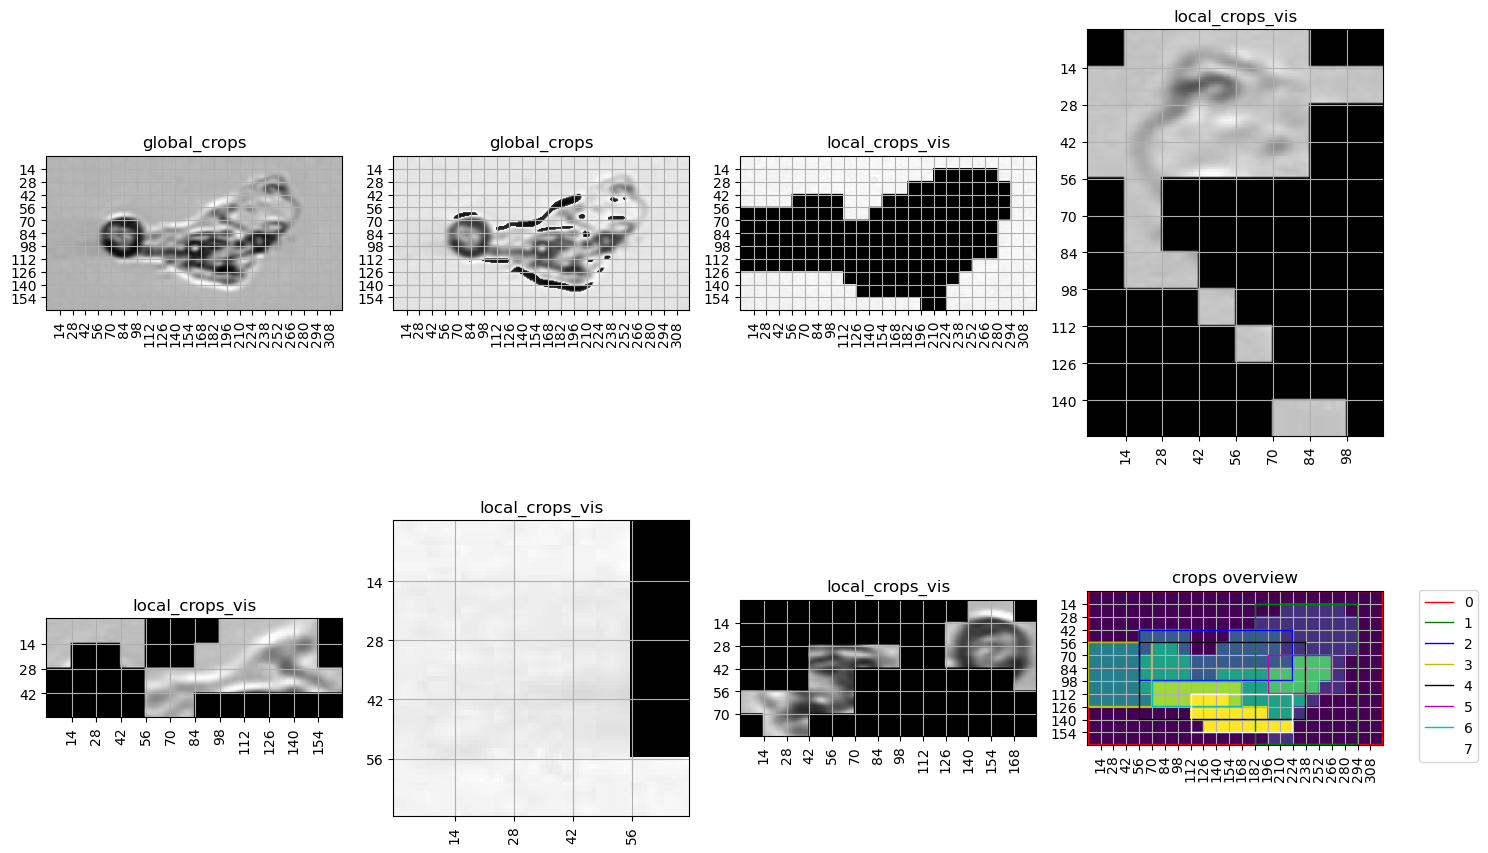

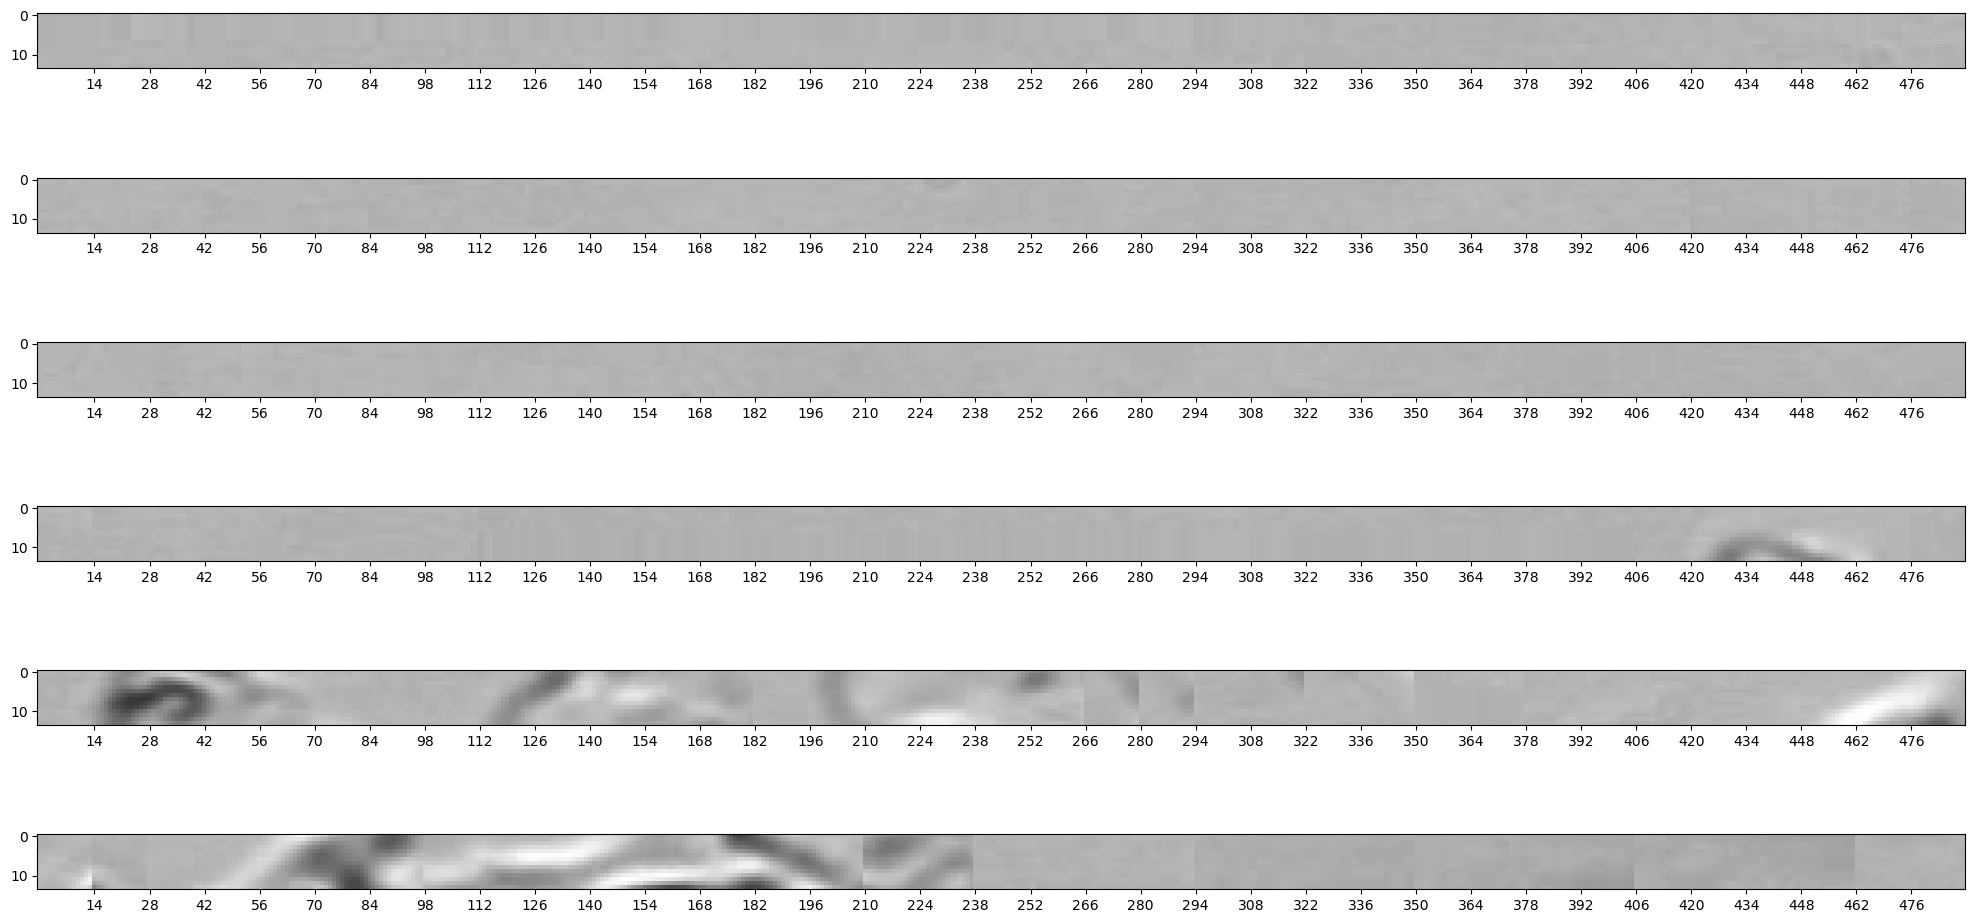

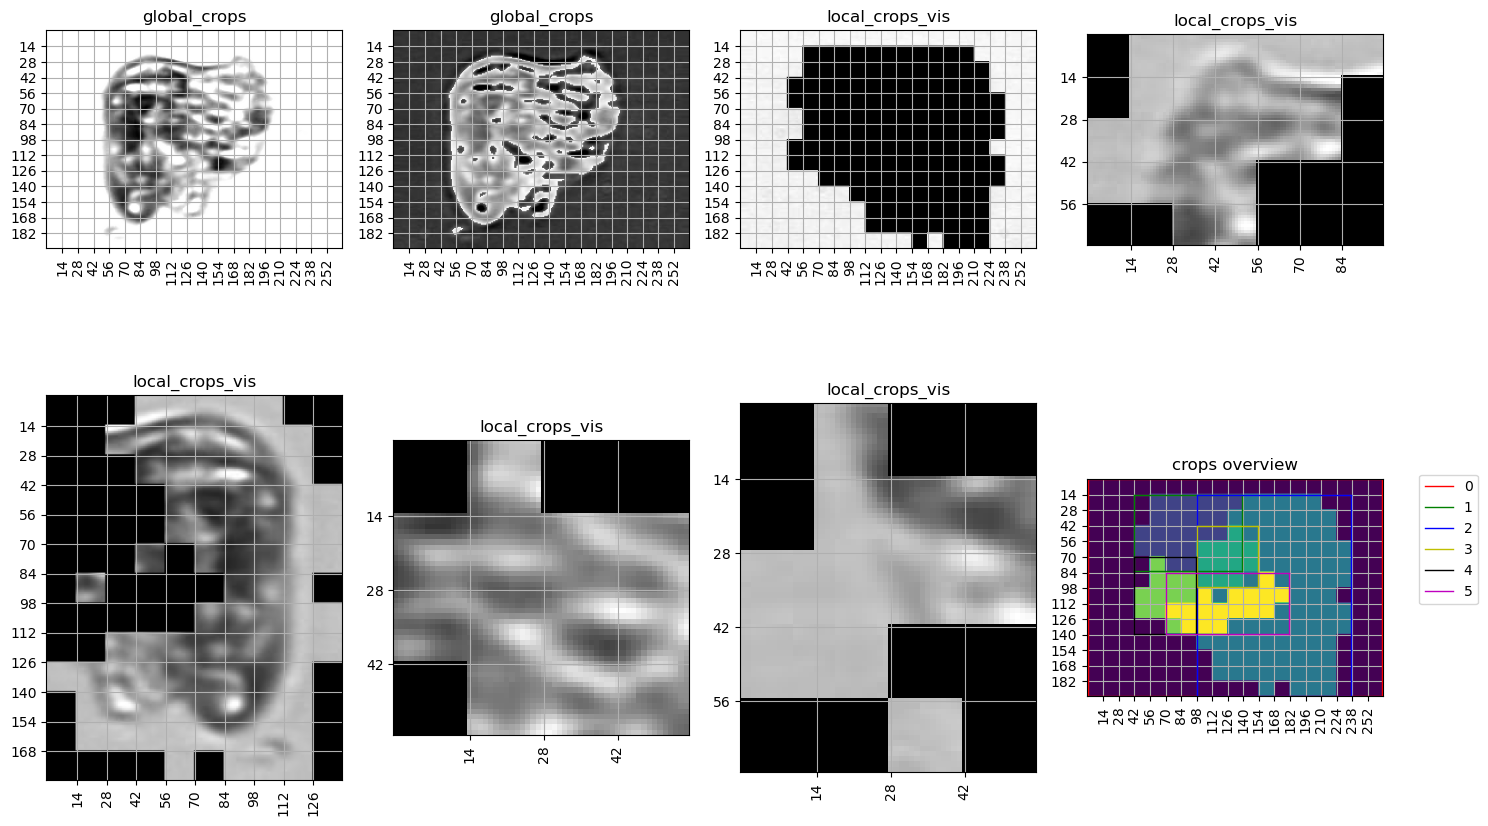

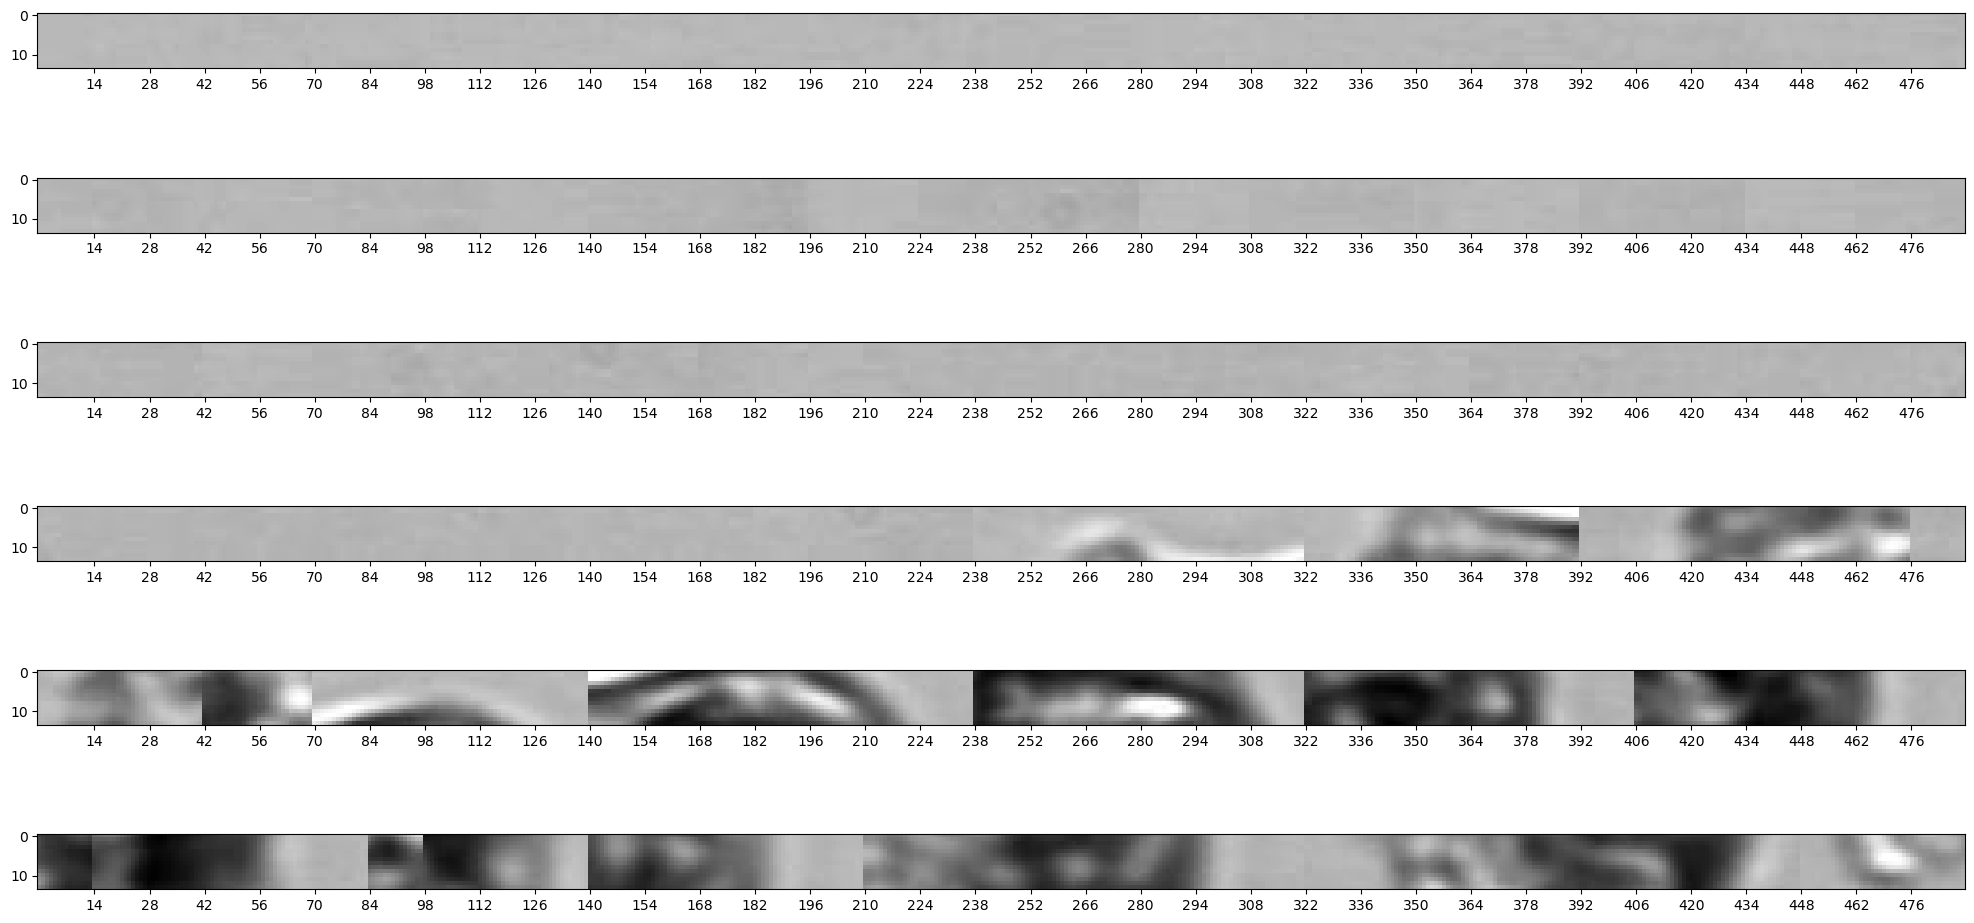

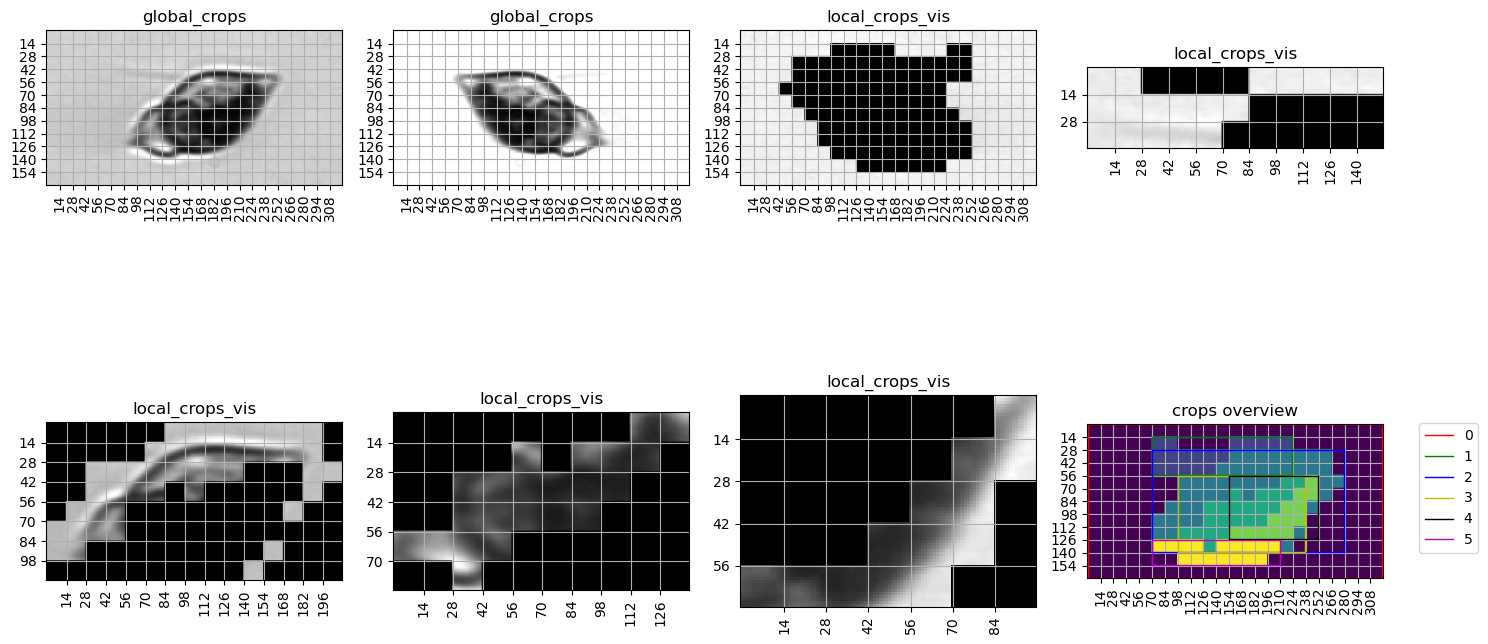

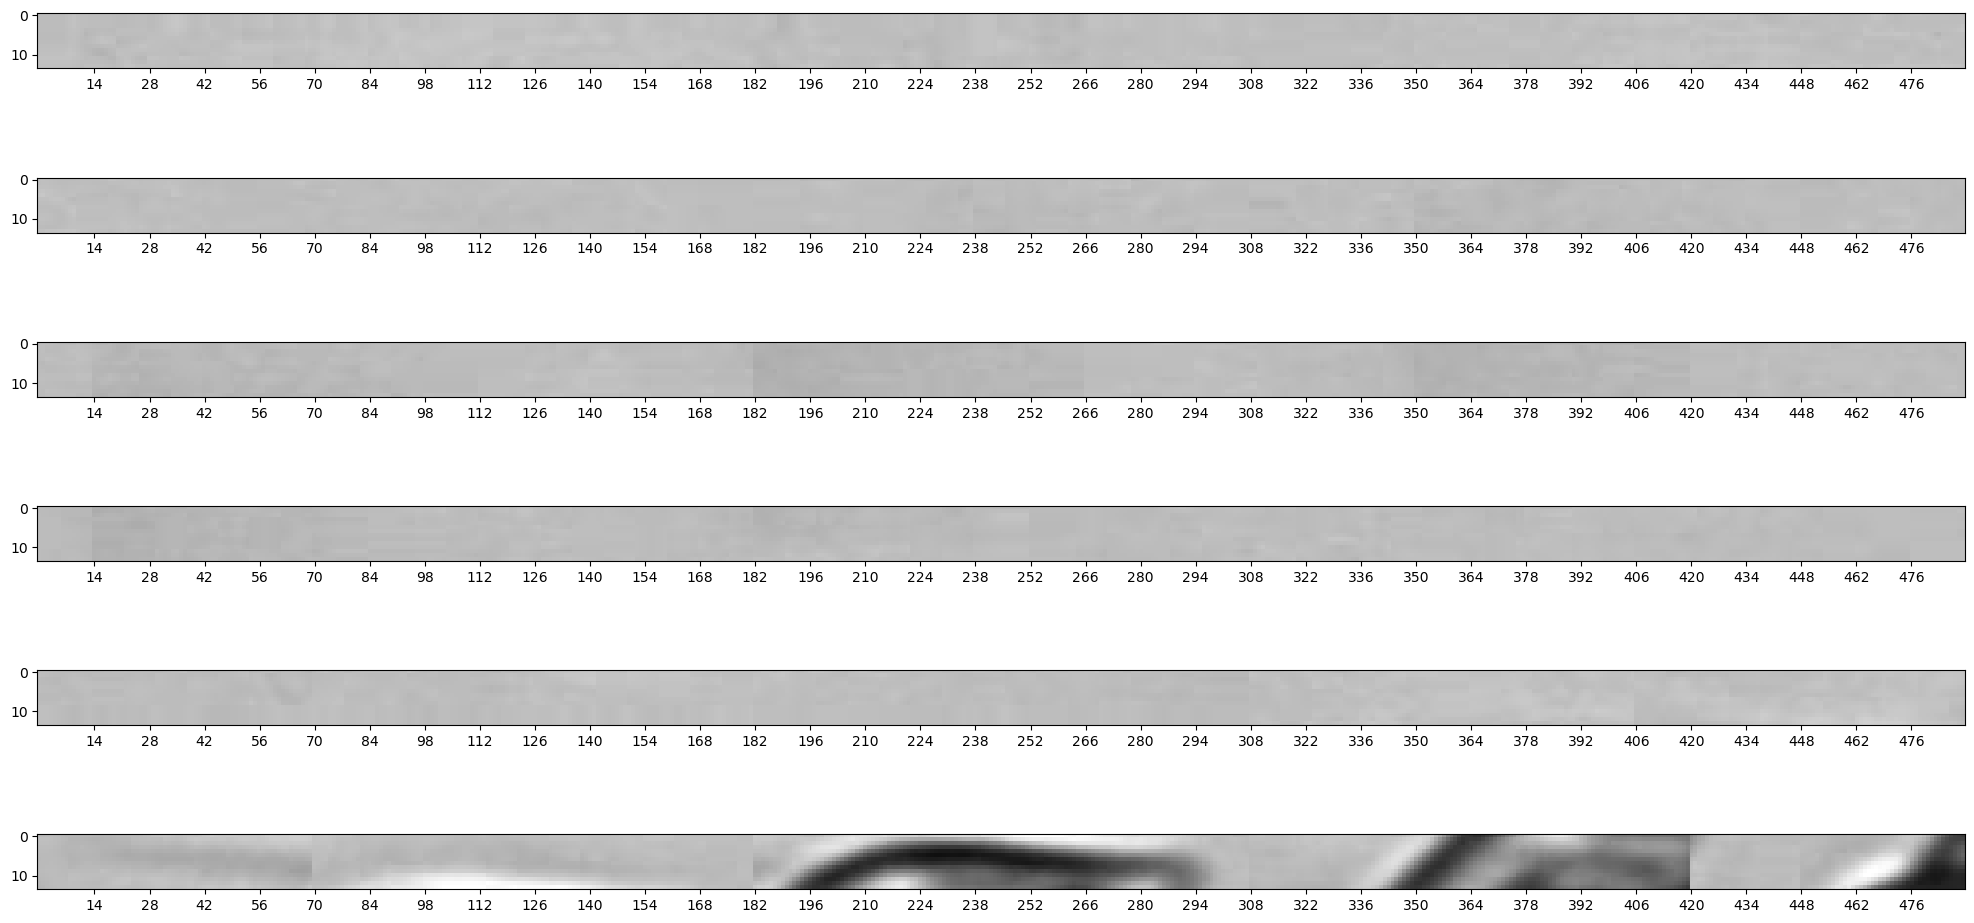

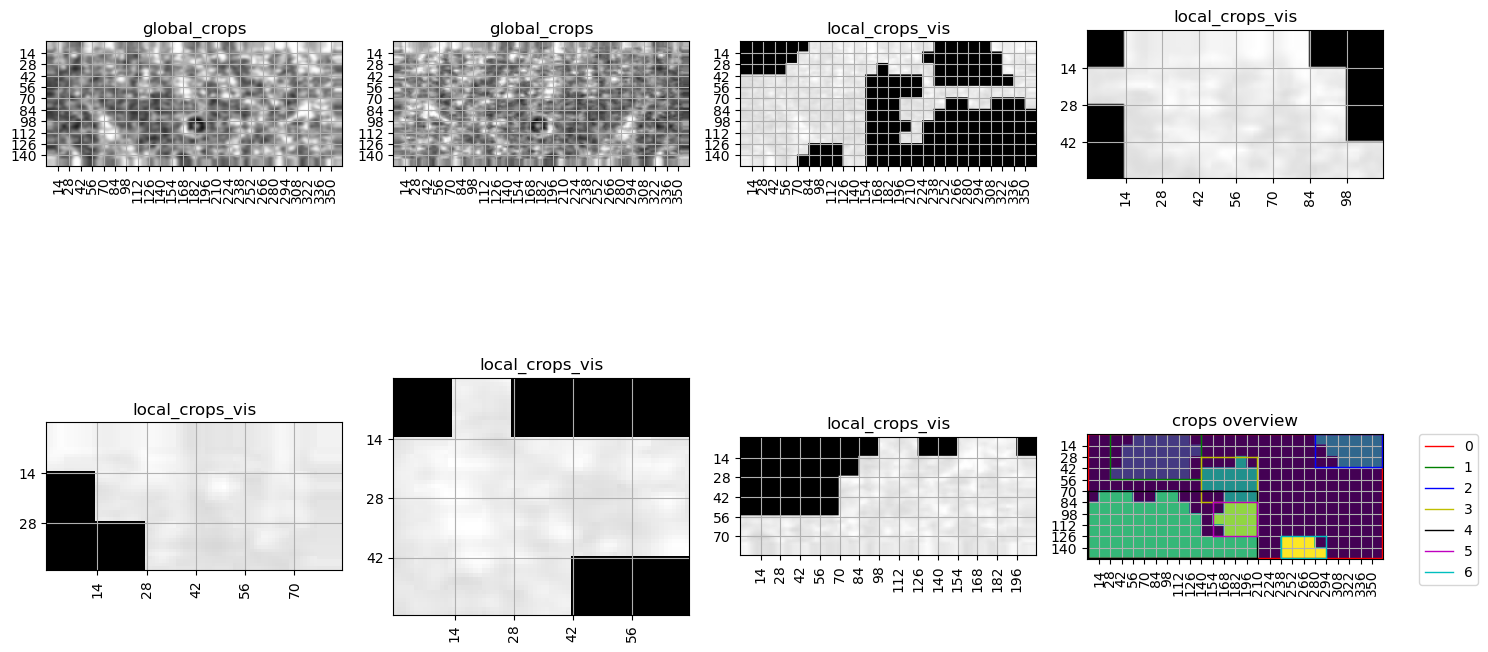

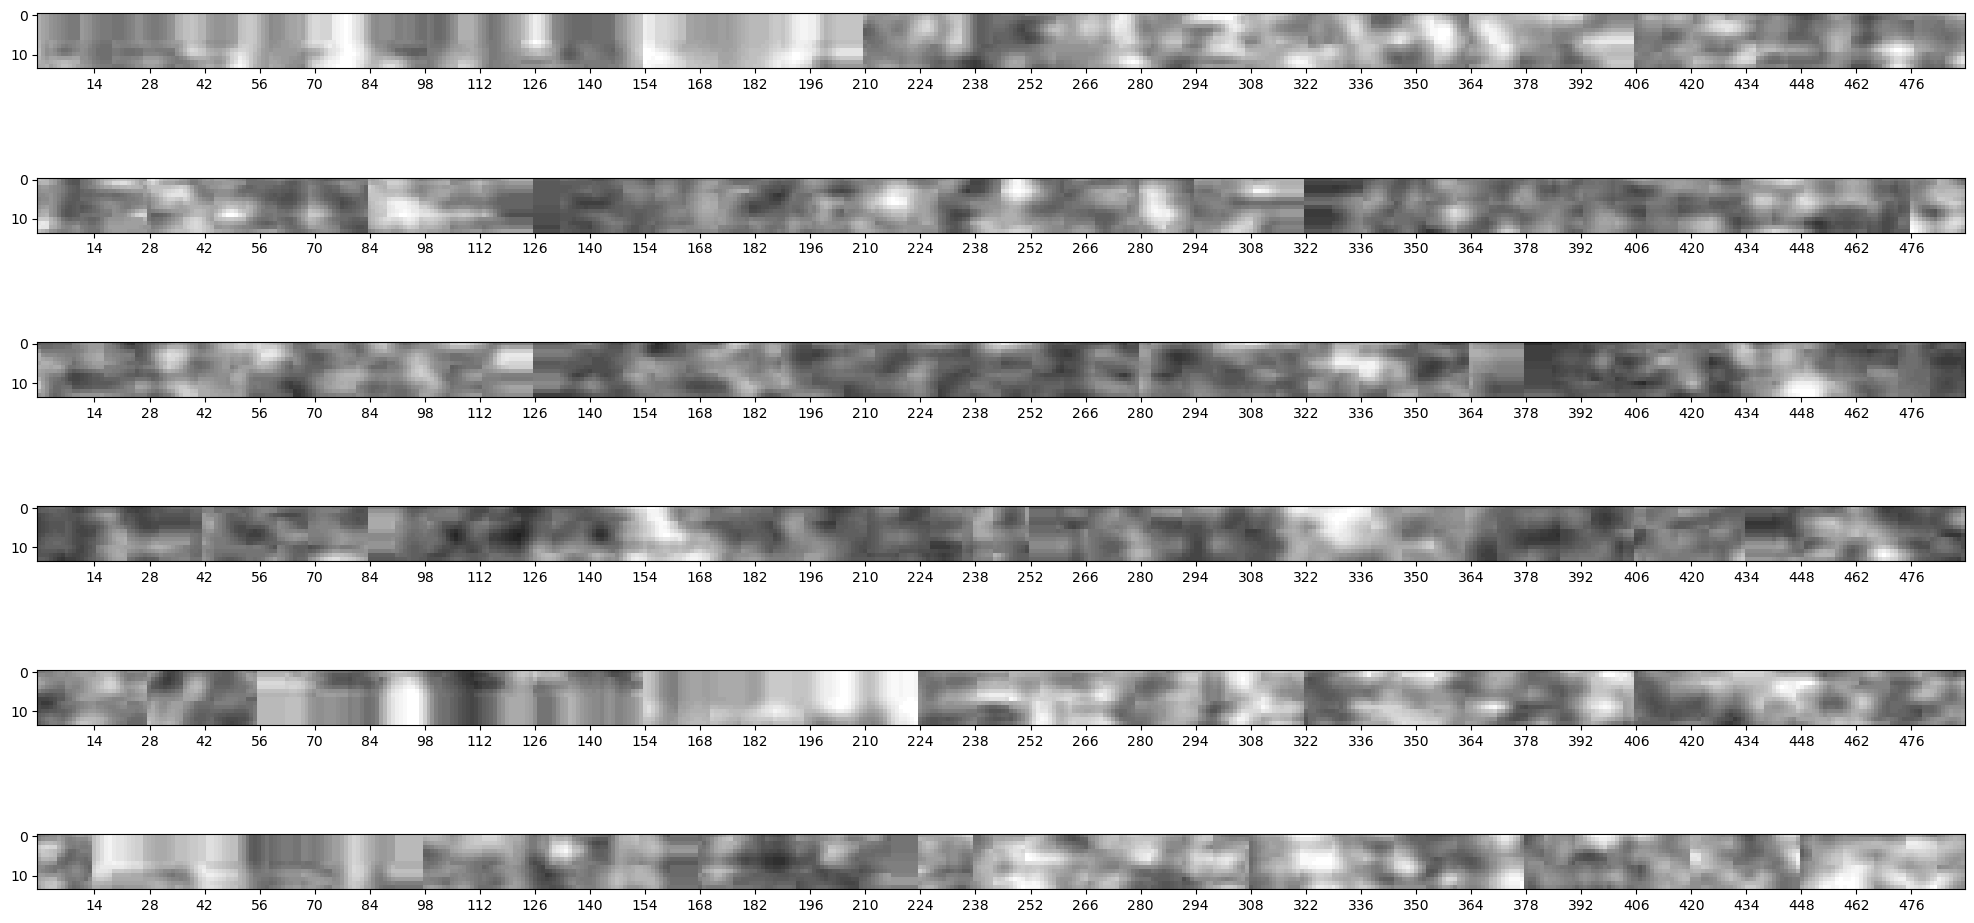

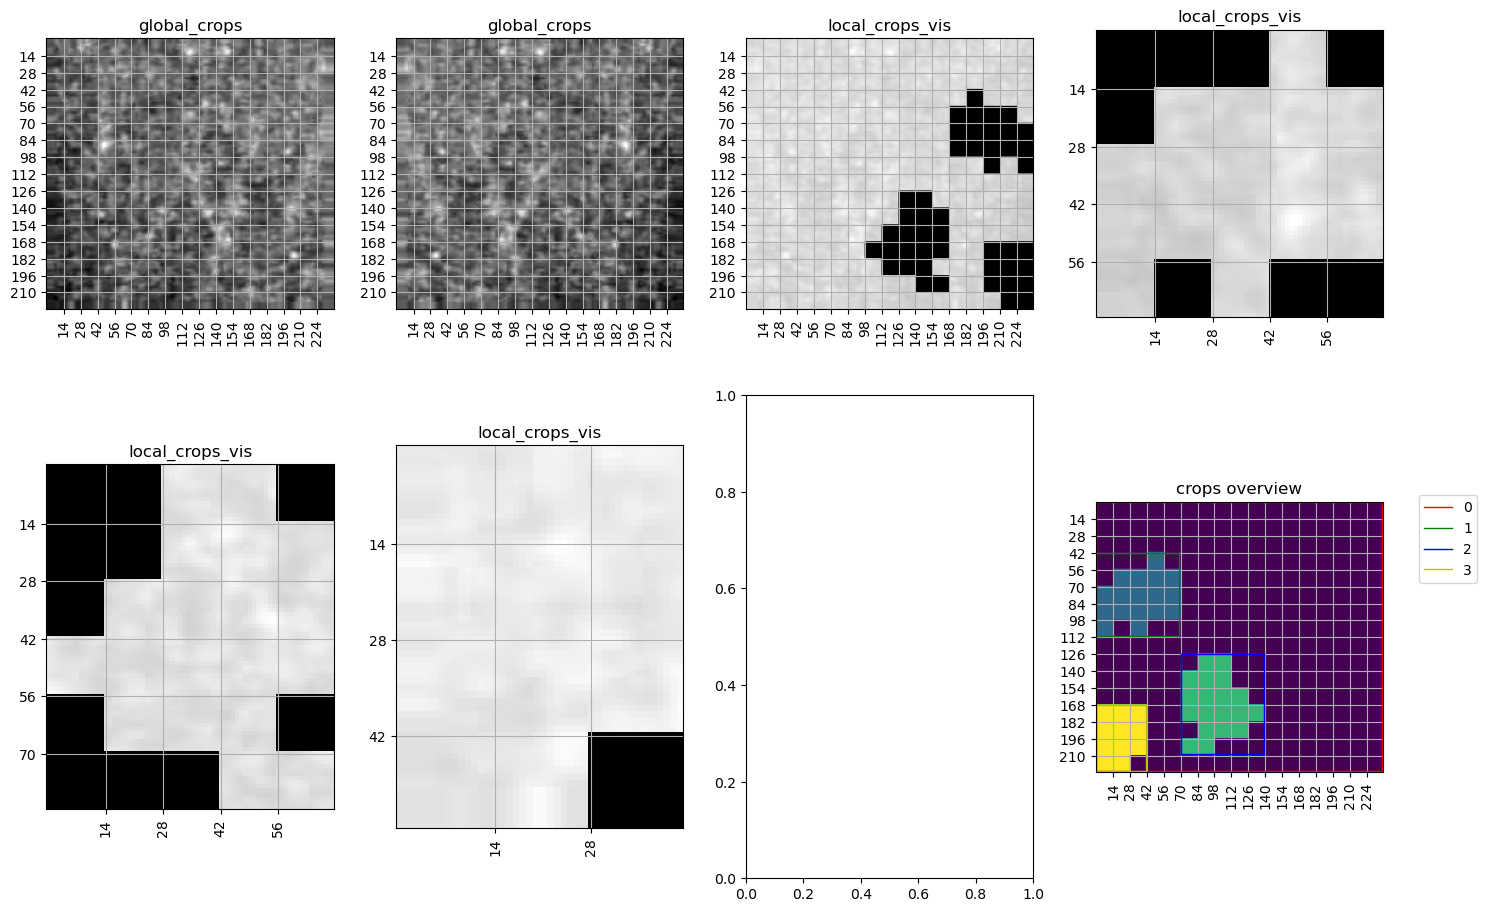

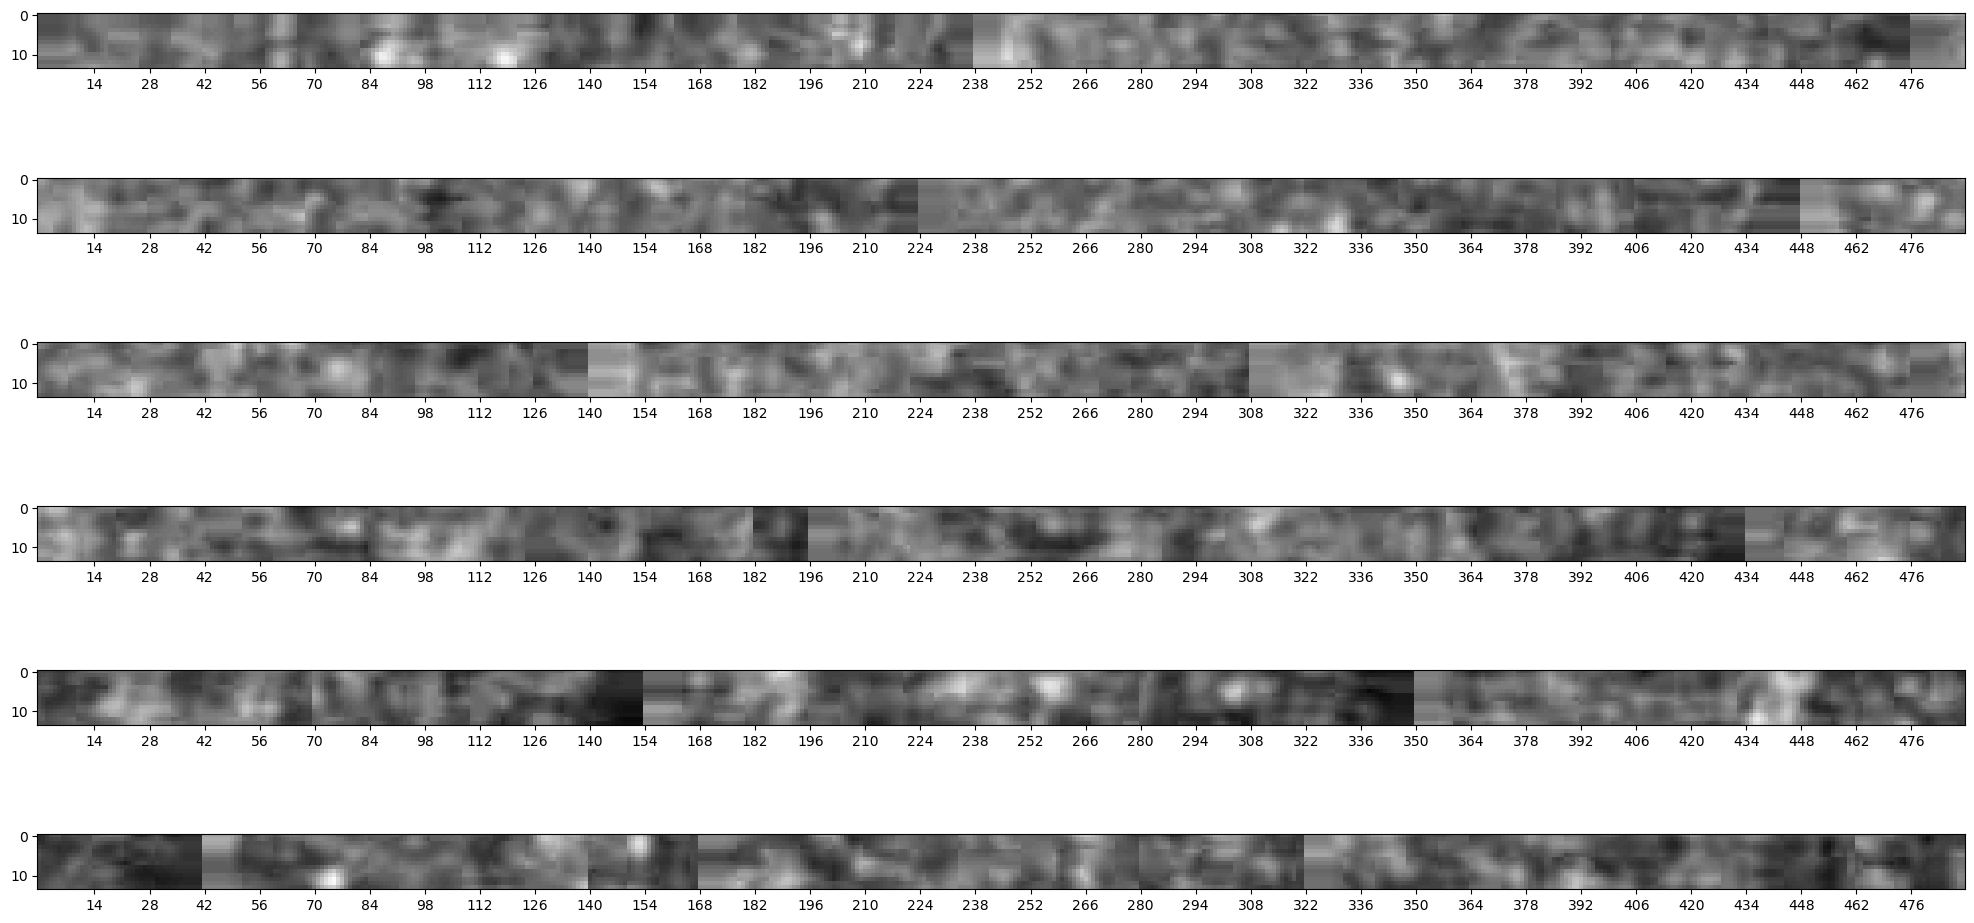

In [9]:
import torch
import numpy as np

for i in range(5):
    # dict_keys(['global_crops', 'local_crops', 'offsets'])
    imgs = dataset[i][0]

    do_plot = True
    """
    for k in imgs.keys():
        for img in imgs[k]:
            if torch.std(img) < 1e-3:
                print(torch.std(img))
                do_plot = True
                break

        # f2, a2 = plt.subplots(1, 1)
        # plt.hist(img.flatten(), bins=40)
    """
    if do_plot:
        nb_x_plots, nb_y_plots = 2, 4
        f, a = plt.subplots(nb_x_plots, nb_y_plots)
        f.set_size_inches(15, 10)
        f.tight_layout()
        count = 0
        for k in ["global_crops", "local_crops_vis"]:
            for img in imgs[k]:
                if len(img.shape) > 3:
                    img = img[0]
                if len(img.shape) == 2:
                    img = img[None, :, :].repeat((3, 1, 1))
                # print("img.shape", count, img.shape)

                norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
                a[count // 4, count % 4].imshow(norm_img.permute(1, 2, 0))
                a[count // 4, count % 4].set_title(k)
                xticks = np.arange(14, norm_img.shape[2], 14)
                yticks = np.arange(14, norm_img.shape[1], 14)
                a[count // 4, count % 4].set_xticks(xticks)
                a[count // 4, count % 4].set_yticks(yticks)
                a[count // 4, count % 4].xaxis.grid(True)
                a[count // 4, count % 4].yaxis.grid(True)
                a[count // 4, count % 4].set_xticklabels(xticks, rotation=90)
                count += 1
                if count // 4 >= nb_x_plots or count % 4 >= nb_y_plots:
                    break
            else:
                continue  # only executed if the inner loop did NOT break
            break
        if "pooled_seg" in imgs.keys():
            img = imgs["pooled_seg"]
            norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            a[-1, -1].imshow(norm_img)
            a[-1, -1].set_title("crops overview")
            colors = ["r", "g", "b", "y", "k", "m", "c", "w"]
            for i, bbox in enumerate(imgs["bboxes"]):
                a[-1, -1].plot(
                    [bbox[0], bbox[2]],
                    [bbox[1], bbox[1]],
                    colors[i % len(colors)],
                    lw=1,
                    label=i,
                )
                a[-1, -1].plot(
                    [bbox[0], bbox[2]],
                    [bbox[3], bbox[3]],
                    colors[i % len(colors)],
                    lw=1,
                )
                a[-1, -1].plot(
                    [bbox[0], bbox[0]],
                    [bbox[1], bbox[3]],
                    colors[i % len(colors)],
                    lw=1,
                )
                a[-1, -1].plot(
                    [bbox[2], bbox[2]],
                    [bbox[1], bbox[3]],
                    colors[i % len(colors)],
                    lw=1,
                )

            xticks = np.arange(14, norm_img.shape[1], 14)
            yticks = np.arange(14, norm_img.shape[0], 14)
            a[-1, -1].set_xticks(xticks)
            a[-1, -1].set_yticks(yticks)
            a[-1, -1].set_xticklabels(xticks, rotation=90)
            a[-1, -1].xaxis.grid(True)
            a[-1, -1].yaxis.grid(True)
            a[-1, -1].legend(bbox_to_anchor=(1.1, 1.05))
            plt.tight_layout()
        if "local_crops" in imgs.keys():
            f, a = plt.subplots(6, 1)
            f.set_size_inches(20, 10)
            f.tight_layout()
            lc = imgs["local_crops"]
            print(lc.shape)
            norm_lc = (lc - torch.min(lc)) / (torch.max(lc) - torch.min(lc))
            for idx in range(0, 2940, 490):
                a[idx // 490].imshow(
                    norm_lc[:, :, idx : idx + 490].permute((1, 2, 0)),
                    label=i,
                )
                a[idx // 490].set_xticks(np.arange(14, 490, 14))

In [4]:
158%14

4

In [5]:
B, C, P = 12, 3, 14
patches = torch.ones((B,C, P, 4*P))

selected_patches = torch.empty(B,C,P,0)

patch_idx = 0

patch = patches[:, :, :, patch_idx : patch_idx + P]  # B C P P
print(patch.shape)
non_zero_idx = torch.mean(patch, dim=(2, 3)) != 0
non_zero_first = torch.any(non_zero_idx, dim=1)
print(non_zero_first)
print(selected_patches[non_zero_first])

selected_patches[non_zero_idx[:, 0]] = np.concatenate(
    patch[non_zero_first, non_zero_idx[0], :, :]
)

torch.Size([12, 3, 14, 14])
tensor([True, True, True, True, True, True, True, True, True, True, True, True])
tensor([], size=(12, 3, 14, 0))


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [12], [3]

In [ ]:
200%14


4

In [ ]:
(168*322)/14


3864.0

In [ ]:
import matplotlib.image as mpimg
from datetime import datetime

path_img = "/home/jluesch/Documents/data/examples/h_and_e_slide_ex.jpg"
img = mpimg.imread(path_img)
img.shape

(517, 735, 3)

In [ ]:
from kornia.augmentation import random_generator as rg

pg = rg.ColorJiggleGenerator(brightness=0.2, contrast=0.4, saturation=0.1, hue=0.2)

pg.forward((10, 65, 3))

{'brightness_factor': tensor([0.9007, 1.0255, 0.9448, 0.9958, 0.9238, 1.0698, 1.1818, 0.9744, 1.1549,
         0.8380]),
 'contrast_factor': tensor([0.8304, 0.7792, 0.8307, 0.7011, 0.6191, 0.8508, 0.6520, 0.6897, 1.3748,
         1.3379]),
 'hue_factor': tensor([ 0.1251,  0.0766, -0.1231, -0.1981,  0.1016, -0.1380, -0.1943,  0.0990,
          0.0761, -0.0010]),
 'saturation_factor': tensor([1.0972, 0.9861, 0.9001, 0.9556, 1.0607, 0.9043, 1.0802, 1.0208, 1.0297,
         1.0700]),
 'order': tensor([2, 3, 0, 1])}

In [ ]:
patch_size = 3
local_crop = torch.zeros((1, 5, 9, 9), dtype=torch.float32)
local_crop[0, :, 0:3, 3:6] = 3
local_crop[0, :, 3:6, 3:6] = 4

print("in", local_crop.shape)

B, C, H, W = local_crop.shape

local_crop = local_crop.flatten(start_dim=2, end_dim=-1)
selected_crops = local_crop[local_crop.nonzero(as_tuple=True)]
selected_crops = local_crop[local_crop.nonzero(as_tuple=True)]

flat_selected_crops = selected_crops.reshape(
    (
        B,
        C,
        int(len(selected_crops) / patch_size / C),
        patch_size,
    )
).permute((0, 1, 3, 2))

print("flat_selected_crops.shape", flat_selected_crops.shape)

in torch.Size([1, 5, 9, 9])
flat_selected_crops.shape torch.Size([1, 5, 3, 6])


In [ ]:
import torch
a = torch.ones((4,5))
a

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [ ]:
from kornia.augmentation import RandomResizedCrop

rrc_op = RandomResizedCrop([224, 224], scale=(0.08, 1.0))

img = dataset[1][0]["local_crops"][0]


rrc_op()

__call__ aug torch.Size([3, 195, 257])
call torch.Size([196, 266])
crop_x, crop_y, single_image.size() 266 196 torch.Size([196, 266])
call torch.Size([196, 266])
crop_x, crop_y, single_image.size() 266 196 torch.Size([196, 266])
call torch.Size([196, 266])
crop_x, crop_y, single_image.size() 266 196 torch.Size([196, 266])
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__prepare_scriptable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_check_inputs', '_extract_params_for_v1_transform', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_

TypeError: forward() missing 1 required positional argument: 'input'

__call__ aug torch.Size([3, 195, 257])
call torch.Size([196, 266])
curr_crops_size 266 196 0 0
70
-70
call torch.Size([196, 266])
curr_crops_size 266 196 0 0
70
-70
call torch.Size([196, 266])
curr_crops_size 266 196 0 0
70
-70
torch.Size([196, 266]) aaa
torch.Size([6, 196, 266]) torch.Size([196, 266])
bbox:  tensor([  0,   0, 265, 195], dtype=torch.int32)
fragment.shape torch.Size([196, 195])
bbox:  tensor([ 42,  14, 139,  83], dtype=torch.int32)
fragment.shape torch.Size([97, 69])
bbox:  tensor([ 98,  14, 223, 195], dtype=torch.int32)
fragment.shape torch.Size([98, 181])
bbox:  tensor([ 98,  42, 153,  97], dtype=torch.int32)
fragment.shape torch.Size([55, 55])
bbox:  tensor([ 28,  70,  97, 139], dtype=torch.int32)
fragment.shape torch.Size([69, 69])
bbox:  tensor([ 70,  84, 167, 139], dtype=torch.int32)
fragment.shape torch.Size([97, 55])
torch.float32 tensor(1.) tensor(0.)
image shape torch.Size([224, 224, 3])
torch.Size([50176, 3])
FZ:  0:00:00.051576
quick #5


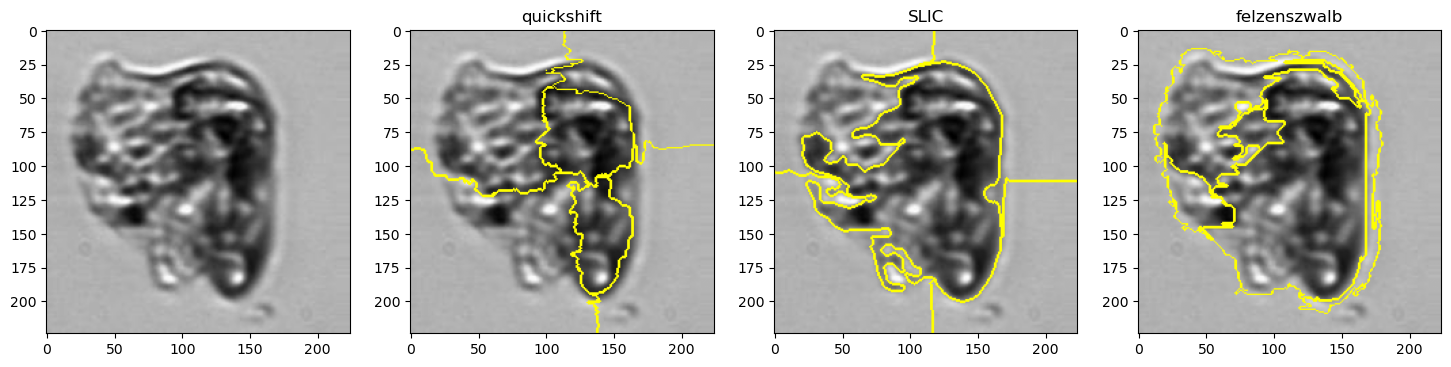

In [ ]:
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
import torchvision
from torchvision.transforms.functional import InterpolationMode

img = dataset[1][0]["global_crops"][0]

if not torch.is_tensor(img):
    img = torch.tensor(img)

# img = imgs["global_crops"][0]
img = (img - img.min()) / (img.max() - img.min())
print(img.dtype, img.max(), img.min())
img = (img * 255).to(torch.uint8)
img_gray = img[0, :, :]

if img.size(0) == 3:
    img = img.permute((1, 2, 0))

orig_img_dims = img.shape[:2]
print(f"image shape {img.shape}")

grid_x, grid_y = torch.meshgrid(
    torch.arange(img_gray.size(0)), torch.arange(img_gray.size(1)), indexing="ij"
)
grid_x = (grid_x - torch.min(grid_x)) / (torch.max(grid_x) - torch.min(grid_x)) * 2
grid_y = (grid_y - torch.min(grid_y)) / (torch.max(grid_y) - torch.min(grid_y)) * 2

preprocessed_data = torch.stack([img_gray, grid_x, grid_y], dim=2).flatten(0, -2)
print(preprocessed_data.size())

segments_quick = quickshift(img, kernel_size=20, max_dist=15, ratio=0.5)
segments_slic = slic(img, n_segments=10, compactness=10, sigma=1.0, start_label=1)
start_t = datetime.now()
segments_fz = felzenszwalb(img, scale=300, sigma=0.5, min_size=700)
delta_fz = datetime.now() - start_t
print('FZ: ', delta_fz)

# saved args
# segments_quick = quickshift(img, kernel_size=7, max_dist=7, ratio=0.5)
# segments_slic = slic(img, n_segments=10, compactness=10, sigma=1.0, start_label=1)
# segments_fz = felzenszwalb(img, scale=150, sigma=0.5, min_size=150)

print(f"quick #{segments_quick.max()}")

kmeans_op = KMeans(n_clusters=10)
res = kmeans_op.fit_predict(preprocessed_data)
img_labels = res.reshape(img_gray.size())

n_plots = 4
f, a = plt.subplots(1, n_plots)
f.set_size_inches(18, 6)
a[0].imshow(img)
a[1].imshow(mark_boundaries(np.array(img), segments_quick))
a[1].set_title("quickshift")
a[2].imshow(mark_boundaries(np.array(img), segments_slic))
a[2].set_title("SLIC")
a[3].imshow(mark_boundaries(np.array(img), segments_fz))
a[3].set_title("felzenszwalb")

# a[4].imshow(img_labels)
# a[4].imshow(mark_boundaries(np.array(img), img_labels))
# for i in range(4, n_plots):
#    a[i].imshow(mark_boundaries(np.array(img), segments_quick == i))

plt.savefig("segmentations.jpg", dpi=200)
plt.show()

In [ ]:
patch_size = 14
local_crop_size = 224
maxpool_op = torch.nn.MaxPool2d(
    kernel_size=patch_size,
    stride=patch_size,
    padding=0,
    dilation=1,
    return_indices=False,
)

# Not used
unpool_op = torch.nn.MaxUnpool2d(kernel_size=patch_size, stride=patch_size, padding=0)

resize_op = torchvision.transforms.Resize(
    orig_img_dims, interpolation=InterpolationMode.NEAREST_EXACT, antialias=False
)

In [ ]:
def seg_to_patched_seg(segments):
    segments = segments / segments.max()
    conv_input = torch.tensor(segments[None, :, :])
    pooled_seg = maxpool_op(conv_input)

    resized_masks = resize_op(pooled_seg)[0, :, :]
    print(np.unique(resized_masks))
    resized_masks_int = (resized_masks * len(np.unique(resized_masks))).to(torch.int32)

    # map tensor to continuous int values
    unique_vals = torch.unique(resized_masks_int)
    lt = torch.full((int(resized_masks_int.max()) + 1,), -1)
    lt[unique_vals] = torch.arange(len(unique_vals))
    resized_masks_int = lt[resized_masks_int]

    return pooled_seg, resized_masks_int

SLIC torch.Size([224, 224, 3])
[0.2 0.4 0.6 0.8 1. ]
# Masks [0 1 2 3 4]
1 4
bbox tensor([112.,   0., 223., 111.])
2 4
bbox tensor([ 14.,  14., 167., 181.])
3 4
bbox tensor([  0.,  98., 111., 223.])


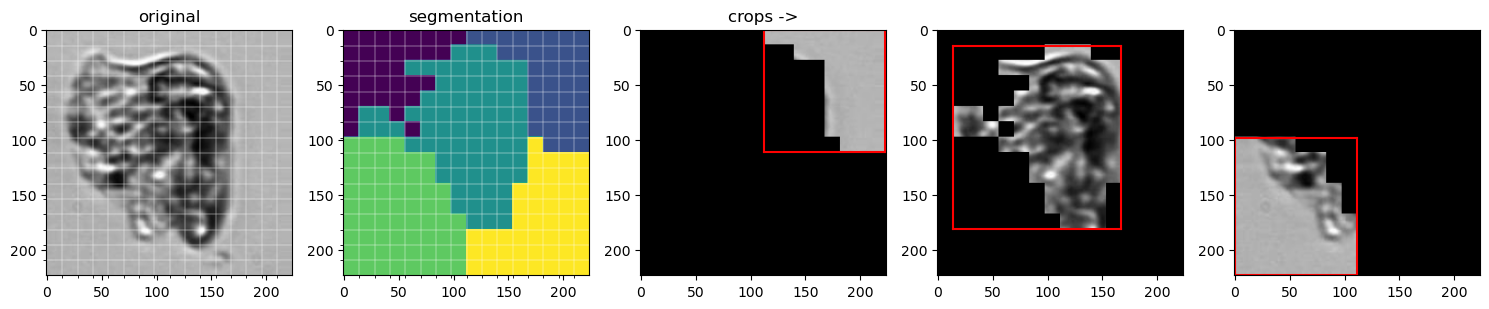

Quickshift torch.Size([224, 224, 3])
[0.  0.2 0.4 0.6 0.8 1. ]
# Masks [0 1 2 3 4 5]
1 5
bbox tensor([  0.,   0., 139., 111.])
2 5
bbox tensor([ 84.,  42., 167.,  97.])
3 5
bbox tensor([126., 126., 153., 167.])


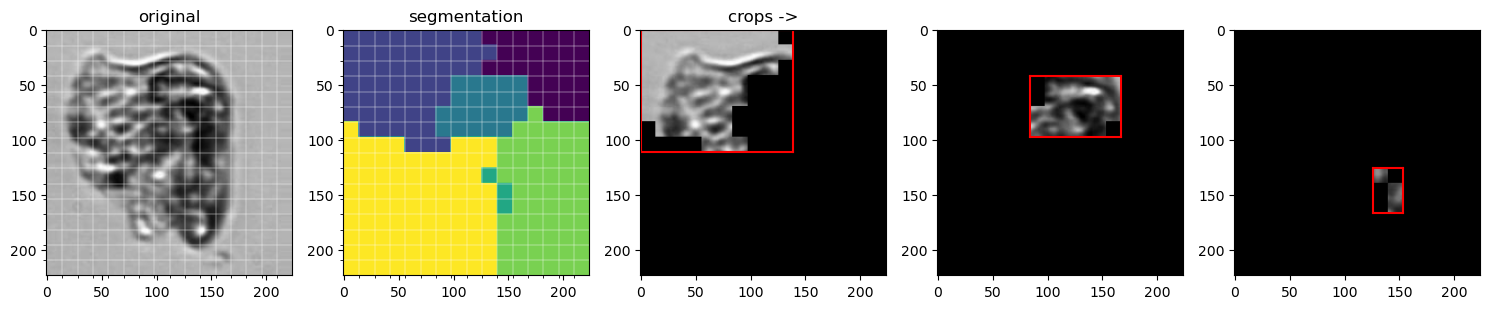

Felzenschwalb torch.Size([224, 224, 3])
[0.  0.2 0.4 0.6 0.8 1. ]
# Masks [0 1 2 3 4 5]
1 5
bbox tensor([ 0., 14., 97., 97.])
2 5
bbox tensor([154.,  14., 181., 195.])
3 5
bbox tensor([ 56.,  14., 181., 209.])


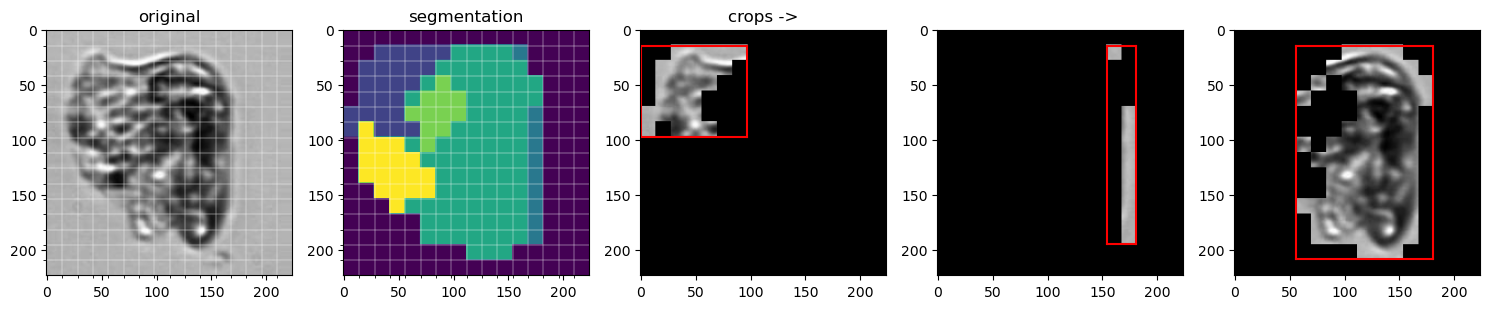

In [ ]:
from torchvision.ops import masks_to_boxes

for seg, name in zip(
    [segments_slic, segments_quick, segments_fz],
    ["SLIC", "Quickshift", "Felzenschwalb"],
):
    print(name, img.shape)
    pooled_seg, resized_masks_int = seg_to_patched_seg(seg)

    max_mask_idx = max(np.unique(resized_masks_int))
    print(f"# Masks {(np.unique(resized_masks_int))}")

    n_plots = 5
    f, a = plt.subplots(1, n_plots)
    f.set_size_inches(15, 7)
    a[0].set_title("original")
    a[1].set_title("segmentation")
    a[2].set_title("crops ->")

    a[0].imshow(img)
    a[0].set_xticks(np.arange(0, img.shape[0], 14), minor=True)
    a[0].set_yticks(np.arange(0, img.shape[1], 14), minor=True)
    a[0].grid(which="minor", color="w", linestyle="-", linewidth=0.3)

    bigger_img = pooled_seg.repeat_interleave(14, dim=1).repeat_interleave(14, dim=2)
    # Alternative
    # a[1].imshow(resize_op(pooled_seg)[0, :, :])
    a[1].imshow(bigger_img[0, :, :])
    a[1].set_xticks(np.arange(0, img.shape[0], 14), minor=True)
    a[1].set_yticks(np.arange(0, img.shape[1], 14), minor=True)
    a[1].grid(which="minor", color="w", linestyle="-", linewidth=0.3)

    img_gray = img[:, :, :1]
    for i in range(2, n_plots):
        mask_idx = i - 1
        print(mask_idx, max_mask_idx)
        if mask_idx > max_mask_idx:
            break
        fragment = torch.zeros(img_gray.shape, dtype=torch.uint8)
        mask_pos = resized_masks_int == mask_idx
        fragment[mask_pos] = img_gray[mask_pos]
        bbox = masks_to_boxes(mask_pos[None, :, :])[0]
        print("bbox", bbox)
        fragment[mask_pos] = fragment[mask_pos]
        a[i].imshow(fragment.repeat([1, 1, 3]))
        a[i].plot([bbox[0], bbox[2]], [bbox[1], bbox[1]], "r-")
        a[i].plot([bbox[0], bbox[2]], [bbox[3], bbox[3]], "r-")
        a[i].plot([bbox[0], bbox[0]], [bbox[1], bbox[3]], "r-")
        a[i].plot([bbox[2], bbox[2]], [bbox[1], bbox[3]], "r-")

    f.tight_layout()
    plt.savefig(f"seg_examples_{name}.jpg", dpi=200, bbox_inches="tight")
    plt.show()

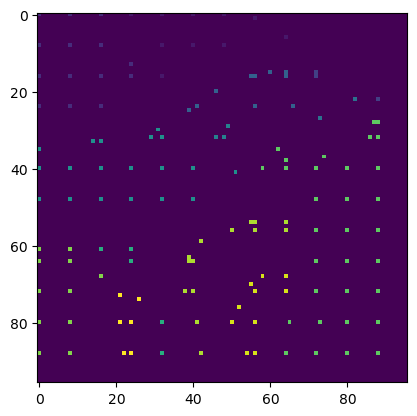

In [ ]:
plt.imshow(unpooled_seg[0,:,:])
plt.show()

In [ ]:
from skimage.segmentation import watershed

watershed(img)

ImportError: /home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/scipy/fft/_pocketfft/pypocketfft.cpython-39-x86_64-linux-gnu.so)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=100, algorithm="ball_tree").fit(preprocessed_data)
distances, indices = nbrs.kneighbors()

In [ ]:
img_labels = torch.zeros(indices.shape[0])

for i in range(indices.shape[0]):
    nbhs = indices[i, :]
    img_labels[nbhs] = i

img_labels = img_labels.reshape(img.size())

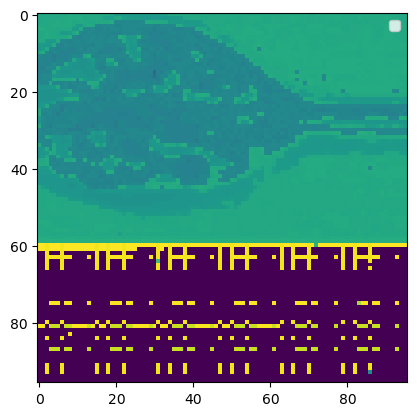

In [ ]:
plt.imshow(img_labels)
plt.legend(img_labels)
plt.show()

In [ ]:
import torch
from skimage.transform import rescale

img = torch.ones(100, 100)

img = rescale(img, 0.2)
img.shape

(20, 20)

In [ ]:
from kornia import augmentation

a = augmentation.RandomResizedCrop(
    [224, 224],
    scale=[0.6,0.8],
    same_on_batch=False,
)

img = torch.ones(10, 10)
print(img)
b=a(img)
b.shape

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


torch.Size([1, 1, 224, 224])